In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import wget
import os
from scipy.stats import chi2
from scipy.stats import t
from tqdm import tqdm
import sympy as sym

In [14]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [15]:
mean = np.mean(sample)
print(mean)

0.9484999999999999


In [16]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size = len(sample), replace = True )
    return resample_

In [17]:
np.mean(Resample(sample))

0.9404

In [18]:
def Bootstrapping(sample,N=10000):
    
    Mean_Dist = np.zeros(N)
    
    for i in tqdm(range(N)):
        resample = Resample(sample)
        Mean_Dist[i] = np.mean(resample)
        
    return Mean_Dist

In [26]:
mean = np.percentile(Mean_Dist,50)
print(mean)
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84] )
q1

0.9480000000000001


array([0.9252, 0.972 ])

In [28]:
Mean_Dist = Bootstrapping(sample)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9872.31it/s]


In [30]:
errorinf = mean-q1[0]
errorsup = q1[1] - mean
print(errorinf,errorsup)

0.022800000000000042 0.0239999999999998


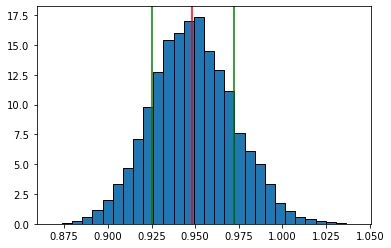

In [29]:
plt.hist(Mean_Dist, bins=30, density=True, ec='k')
plt.axvline(x=mean,color='r')
plt.axvline(x=q1[0],color='g')
plt.axvline(x=q1[1],color='g')

$$ \hat{\mu} = 0.948_{0.022}^{0.023}  at 68\% CL $$

In [3]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 521 / 521File loaded


In [4]:
Data = np.loadtxt(Path_)

In [5]:
x = Data[:,0]
y = Data[:,1]
N = len(x)
sigma = np.random.uniform(1,4,size=N)
sigma

array([1.56132773, 1.20791469, 3.82056598, 2.79839039, 2.98582766,
       1.67593552, 1.80111014, 1.53861692, 2.06682515, 1.73587712,
       3.0356407 , 2.50046338, 1.77346371, 1.36183865, 1.00889001,
       3.16188915, 3.09148812, 2.39147683, 3.93831087, 1.23481701])

In [6]:
def GetFit(x,y,n=3):
    
    size = len(x)
    b = y
    
    A = np.ones((size,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**(i)

    # Hacer ajuste cuadratico
    
    M = np.dot(A.T,A)
    bt = np.dot(A.T,b)
    
    xsol = np.linalg.solve(M,bt)

    return xsol

In [7]:
n = 2 # order of the polynomial
param = GetFit(x,y,n=n)
print(param)

[1.22132054 6.09075205 2.9565874 ]


In [8]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
    
    return y

In [9]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.95658740177385*x**2 + 6.0907520463624*x + 1.2213205361703

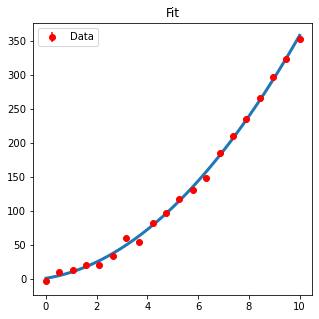

In [10]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')
ax.plot(t,GetModel(t,param),lw=3) 
#ax.plot(t,GetModel(t,param), label="Parameters: {0}".format(np.round(param,2))) 
ax.legend(loc=0)

In [11]:
def GetChi2(x,y,sigma,p,reducido=True):
    
    df = (len(x) - len(p) - 1) 
    
    if not reducido:
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) , df
    else:   
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) / df ,df

In [12]:
param = GetFit(x,y,n)
Chi2,df = GetChi2(x,y,sigma,param)
print(Chi2)

12.236296441899388


# Bootstraping